In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14802706904639690369
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4834983936
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7338600036375578744
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [5]:
import os

import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from PIL import ImageFont
import visualkeras

In [6]:
"""all_img_names = []
for dirname, _, filenames in os.walk('combined_faces/'):
    for filename in filenames:
        all_img_names.append( os.path.join(dirname, filename))
"""
img_dir = "combined_faces/"

all_img_names=os.listdir(img_dir)

print('Total images ', len(all_img_names))

Total images  33486


In [7]:
all_img_names[500:510]

['12_134.jpg',
 '12_135.jpg',
 '12_136.jpg',
 '12_137.jpg',
 '12_138.jpg',
 '12_139.jpg',
 '12_14.jpg',
 '12_140.jpg',
 '12_141.jpg',
 '12_142.jpg']

In [8]:
seed_constant = 27
random.seed(seed_constant)

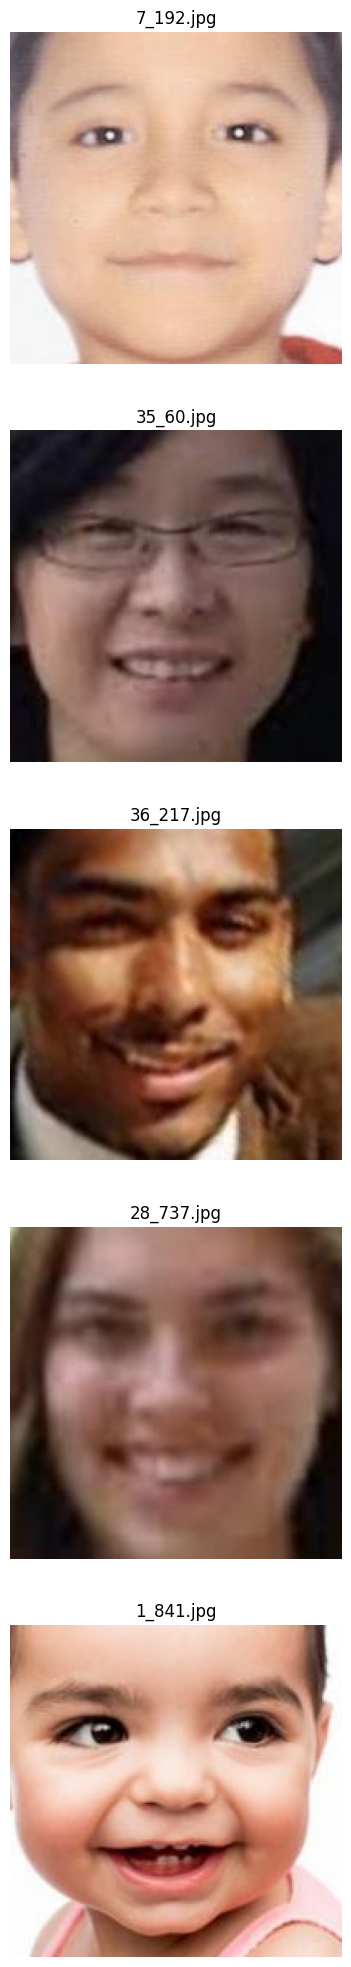

In [9]:
# Create a Matplotlib figure.
plt.figure(figsize=(25,25))

# Generate a list of 5 random values. The values should be less than number of images in dataset.
random_range = random.sample(range(len(all_img_names)), 5)

#Iterate through random values
for counter, random_index in enumerate(random_range, 1):
  
  #Name of the selected image
  img_name=all_img_names[random_index]

  #Path of the selected image
  img_path=os.path.join(img_dir,img_name)

  #Read the selected image in BGR format
  bgr_img=cv2.imread(img_path)

  #Convert it into RGB format
  rgb_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)

  #Display the selected image
  plt.subplot(5, 1, counter)
  plt.imshow(rgb_img)
  plt.title(img_name)
  plt.axis('off')

# Pre-process the Dataset


In [10]:
img_height=224
img_width=224

In [11]:
def image_preprocessing(img_path):
    
    
    #Read the image
    img=cv2.imread(img_path)
    
    #Resize the image 
    resized_img=cv2.resize(img,(img_height,img_width))
    
    #Normalize the image
    normalized_img=resized_img/255
    
    return normalized_img

In [12]:
def label_extraction(img_name):
    
    '''
    This function will extract age from image name and return the class index by performing integer division (by 25).
    Args:
        img_name: The name of the image.
    Returns:
        class_index: An integer representing the age class.
    '''
    #Extract age 
    age=int(img_name.split("_")[0])
    
    #Class index dividing by 25
    class_index=age//25
    
    
    return class_index

In [13]:
def create_dataset():    
    
    #Declare empty lists to store features and labels.
    
    features=[]
    labels=[]
    
    for img_name in all_img_names:
        
        #Path of the image
        img_path=os.path.join(img_dir,img_name)
            
        #Get the preprocessed image
        preprocessed_img=image_preprocessing(img_path)
            
        #Get the class index
        class_index=label_extraction(img_name)
            
        #Append data into appropriate lists
        features.append(preprocessed_img)
        labels.append(class_index)
        
            
    #Convert lists to numpy arrays
    features=np.asarray(features)
    labels=np.asarray(labels)
    
    return features,labels

In [14]:
#Create the dataset
features,labels=create_dataset()

MemoryError: Unable to allocate 37.6 GiB for an array with shape (33486, 224, 224, 3) and data type float64

In [ ]:
print(labels[40:48],features[:3])

In [ ]:
encoded_labels=np_utils.to_categorical(labels)

In [18]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

NameError: name 'features' is not defined

In [17]:
#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=features_train.shape[1:], weights='imagenet', include_top=False)

#Prevent training already trained layers 
for layer in vgg.layers[:-4]:
  layer.trainable = False

#Add flatten layer
x = Flatten()(vgg.output)

#More Dense layers

#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.2)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.2)(x)

# Add more dense layers
x = Dense(1000, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)

x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(labels_train.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

NameError: name 'features_train' is not defined

In [ ]:
#selected font
arialtf = "font/arial.ttf"
font = PIL.ImageFont.truetype(arialtf, 32)
visualkeras.layered_view(model, font=font)

In [15]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Callbacks
callbacks_list=[early_stopping_callback,checkpoint]

#Compile the model with multiple metrics
metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = metrics)

# Start training the model.
history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size=32, shuffle = True, validation_split = 0.1, 
                    callbacks = callbacks_list )

NameError: name 'model' is not defined

In [ ]:
# load weights of model with best validation accuracy
model.load_weights("weights.best.hdf5")

In [ ]:
model_evaluation_history_base = model.evaluate(features_test, labels_test)

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

In [ ]:
# Construct a range object 
epochs = range(len(history.history["loss"]))
# Plot the Graph.
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
# Add title 
plt.title("Total Loss and Total Validation Loss")
# Add legend 
plt.legend()

In [ ]:
# Construct a range object 
epochs = range(len(history.history["accuracy"]))
# Plot the Graph.
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
# Add title 
plt.title("Total Accuracy and Total Validation Accuracy")
# Add legend 
plt.legend()